# DSC-037 step 4: Compute delay power spectra


---

**DSC-037**: Cable reflection systematics for EoR science

**Author:** Adélie Gorce and Teal team 

**Documentation on confluence:** 
- DSC description page: https://confluence.skatelescope.org/x/0rs6F
- Chronological walkthrough: https://confluence.skatelescope.org/x/osw6F
- Implementation: https://confluence.skatelescope.org/x/n8LMF
- GitHub repo: https://github.com/uksrc-developers/dsc-037-eor

**Summary:**  This notebook is a first implementation of the step 4 of DSC-037 (see chronological walkthrough above) to calculate delay power spectra for individual baselines and then cylindrically averaged power spectra for a user-specified set of frequencies, times, and polarisations.
In this notebook, we
- Load the visibilities
- Compute a delay power spectrum for a single antenna (and all associated baselines) using the `pyuvdata` and `hera_pspec` packages


**Ticket:** TEAL-1129 https://jira.skatelescope.org/browse/TEAL-1129


**Data:**
We use the MWA dataset available on Rucio (https://confluence.skatelescope.org/x/tnTGEg) as a proxy for DV AA2 data. The dataset has the following structure:
- Integration time: 8s
- Total time: 112s
- Bandwidth: 31 MHz
- Central frequency: 182 MHz
- Number of channels: 384
- Channel width: 80 kHz
- Processing applied: DI-calibration and sky model subtraction
- Calibration solutions available
- Size: 1.9 GB




In [ ]:
# import required packages
import numpy as np
from astropy.time import Time
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps

In [2]:
import hera_pspec as hp
import pyuvdata
from utils import load_config

In [3]:
print(*(f"{pkg} version: {__import__(pkg).__version__}" for pkg in ['numpy', 'astropy', 'matplotlib', 'pyuvdata', 'hera_pspec']), sep='\n')

numpy version: 2.2.4
astropy version: 7.0.1
matplotlib version: 3.10.1
pyuvdata version: 3.2.1
hera_pspec version: 0.4.3.dev89+ge63e2a1.d20250801


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load configuration

The antenna(s), time range, frequency range, polarization to analyse are specified in a configuration file. 
The configuration file also specifies the datafile to consider and its location.
The information is then loaded with the `load_config` method.

In [5]:
dic = load_config('init.yaml', verbose=True)

No antennas specified; using all antennas in data (121).
No times specified; using all timestamps in data (14).
Loaded MWA dataset with required configuration.
Selected frequency range: [175.075, 183.075] MHz, corresponding to average redshift of 6.93.
Selected polarization: -5 (xx)


## Inspect dataset

Load the metadata to inspect global dataset

In [6]:
uvd_meta = pyuvdata.UVData()
uvd_meta.read_uvfits(os.path.join(dic['datafolder'], dic['datafile']), read_data=False)

In [7]:
print(f'Number of baselines: {uvd_meta.Nbls}')
print(f'Number of times: {uvd_meta.Ntimes}')
print(f'Number of frequencies: {uvd_meta.Nfreqs}')
print(f'Number of polarizations: {uvd_meta.Npols} ({uvd_meta.polarization_array})')

Number of baselines: 7381
Number of times: 14
Number of frequencies: 384
Number of polarizations: 4 ([-5 -6 -7 -8])


In [ ]:
# for now, no beam
uvb = None
# MWA beam model (from Dev)
# beamfile = 'mwa_full_embedded_element_pattern.h5'
# # read in delays to adjust zero phase of beam
# from astropy.io import fits
# metafits_file = datafile.split('_')[1]+'.metafits'
# with fits.open(os.path.join(datafolder, metafits_file)) as hdul:
#     data = hdul['TILEDATA'].data
# delays = np.array([data[0]['Delays'], data[0]['Delays']])
# # create UVBeam object and read in MWA beam
# uvb = pyuvdata.UVBeam()
# uvb.read_mwa_beam(os.path.join(datafolder, beamfile), delays=delays)

## Baseline-averaged delay-PS grouped by antenna

Build delay power spectra, but only for baselines including a specific antenna.

In [ ]:
# find indices to select frequency range (use in hp.pspec)
spw_ranges = [tuple([list(uvd_meta.freq_array).index(dic['freq_range'][i]*1e6) for i in (0, 1)])  ]

In [ ]:
# loop over antennas to build delay power spectra
data_time_avg = np.zeros((len(dic['antenna_nums']), np.diff(spw_ranges[0])[0]//2-1))
data_per_antenna = np.zeros((len(dic['antenna_nums']), dic['Ntimes'], np.diff(spw_ranges[0])[0]//2-1))
for u, antenna_num in enumerate(tqdm(dic['antenna_nums'])):
    # create UVData object and read in data
    uvd = pyuvdata.UVData()
    uvd.read(
        os.path.join(dic['datafolder'], dic['datafile']),
        polarizations=[dic['pol']],
        time_range=dic['time_range'],
        # freq_chans=np.arange(spw_ranges[0][0], spw_ranges[0][1]),
        keep_all_metadata=False,
        read_data=True,
    )
    # select data for a single antenna
    uvd.select(ant_str=f'{antenna_num}')
    # average over all the baselines including said antenna
    uvd.compress_by_redundancy(tol=100000., use_grid_alg=True)
    # Create a new PSpecData object which will be used to compute the delay PS
    ds = hp.PSpecData(dsets=[uvd, uvd], wgts=[None, None], beam=uvb)
    # in the baseline-averaged dataset, there is only one baseline left (the first one)
    bl = uvd.baseline_to_antnums(uvd.baseline_array[0])
    # build time-averaged delay ps from pairing the baseline with itself
    uvp = ds.pspec(
        [bl], [bl], # select the baselines to cross (here, with itself)
        dsets=(0, 1), # select which datasets to use within ds
        pols=[(dic['pol'], dic['pol'])],  # select the polarisation channels to cross
        spw_ranges=spw_ranges,  # select a smaller bandwidth
        verbose=False
    )
    # save time array for per-antenna figure
    if u == 0:
        time_array = Time(uvp.time_avg_array, format='jd')
    # fold spectrum over the delay axis
    hp.grouping.fold_spectra(uvp)
    # save delay power spectrum per antenna, as a function of time and delay
    data_per_antenna[u] = np.abs(uvp.data_array[0][:, -uvp.get_dlys(0).size:, 0])
    # take time average of the data
    uvp.average_spectra(time_avg=True, inplace=True)
    # save time-averaged delay power spectrum per antenna
    data_time_avg[u] = np.abs(uvp.data_array[0][0, -uvp.get_dlys(0).size:, 0])
# define time array for per-antenna figure
t_ref = Time(uvp.time_avg_array.min(), format='jd')
time_array = (time_array - t_ref).to('s').value

100%|██████████| 121/121 [04:17<00:00,  2.13s/it]


Gather the results in a figure presenting the time-averaged delay PS per antenna ($x$ axis) to identify which antennas are the most impacted by cable reflections

Text(0.5, 0, 'Antenna number')

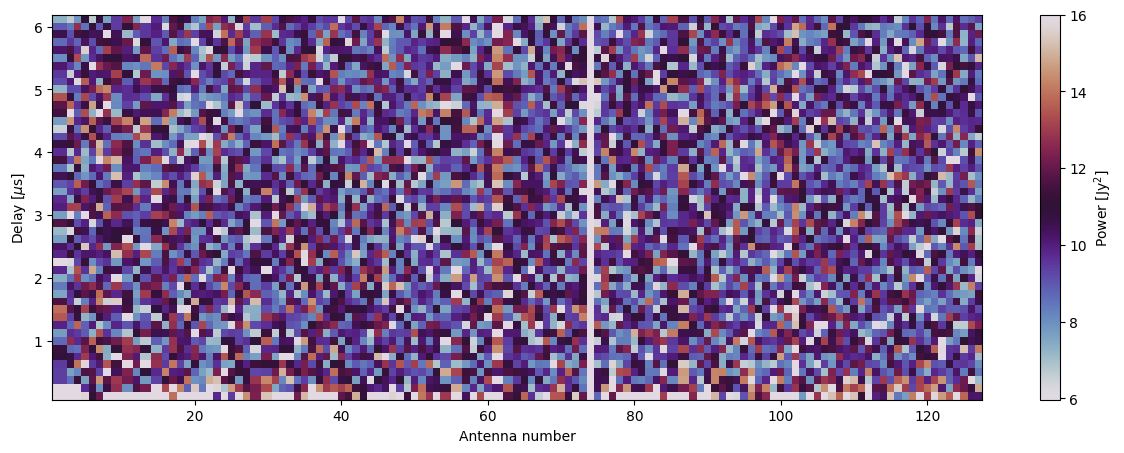

In [12]:
vmin = np.percentile(np.abs(data_time_avg), 2)
vmax = np.percentile(np.abs(data_time_avg), 98)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
im = ax.pcolormesh(
    dic['antenna_nums'],
    uvp.get_dlys(0)*1e6,
	np.abs(data_time_avg).T,
	cmap='twilight',
    norm=colors.Normalize(vmin=vmin, vmax=vmax),
)
cbar = fig.colorbar(im, ax=ax, label=r'Power [Jy$^2$]')
ax.set_ylabel(r'Delay [$\mu$s]')
ax.set_xlabel('Antenna number')

Gather the results in a figure showing the delay power spectrum as a function of time for each antenna, in order to identify which antenna is most impacted by cable reflections

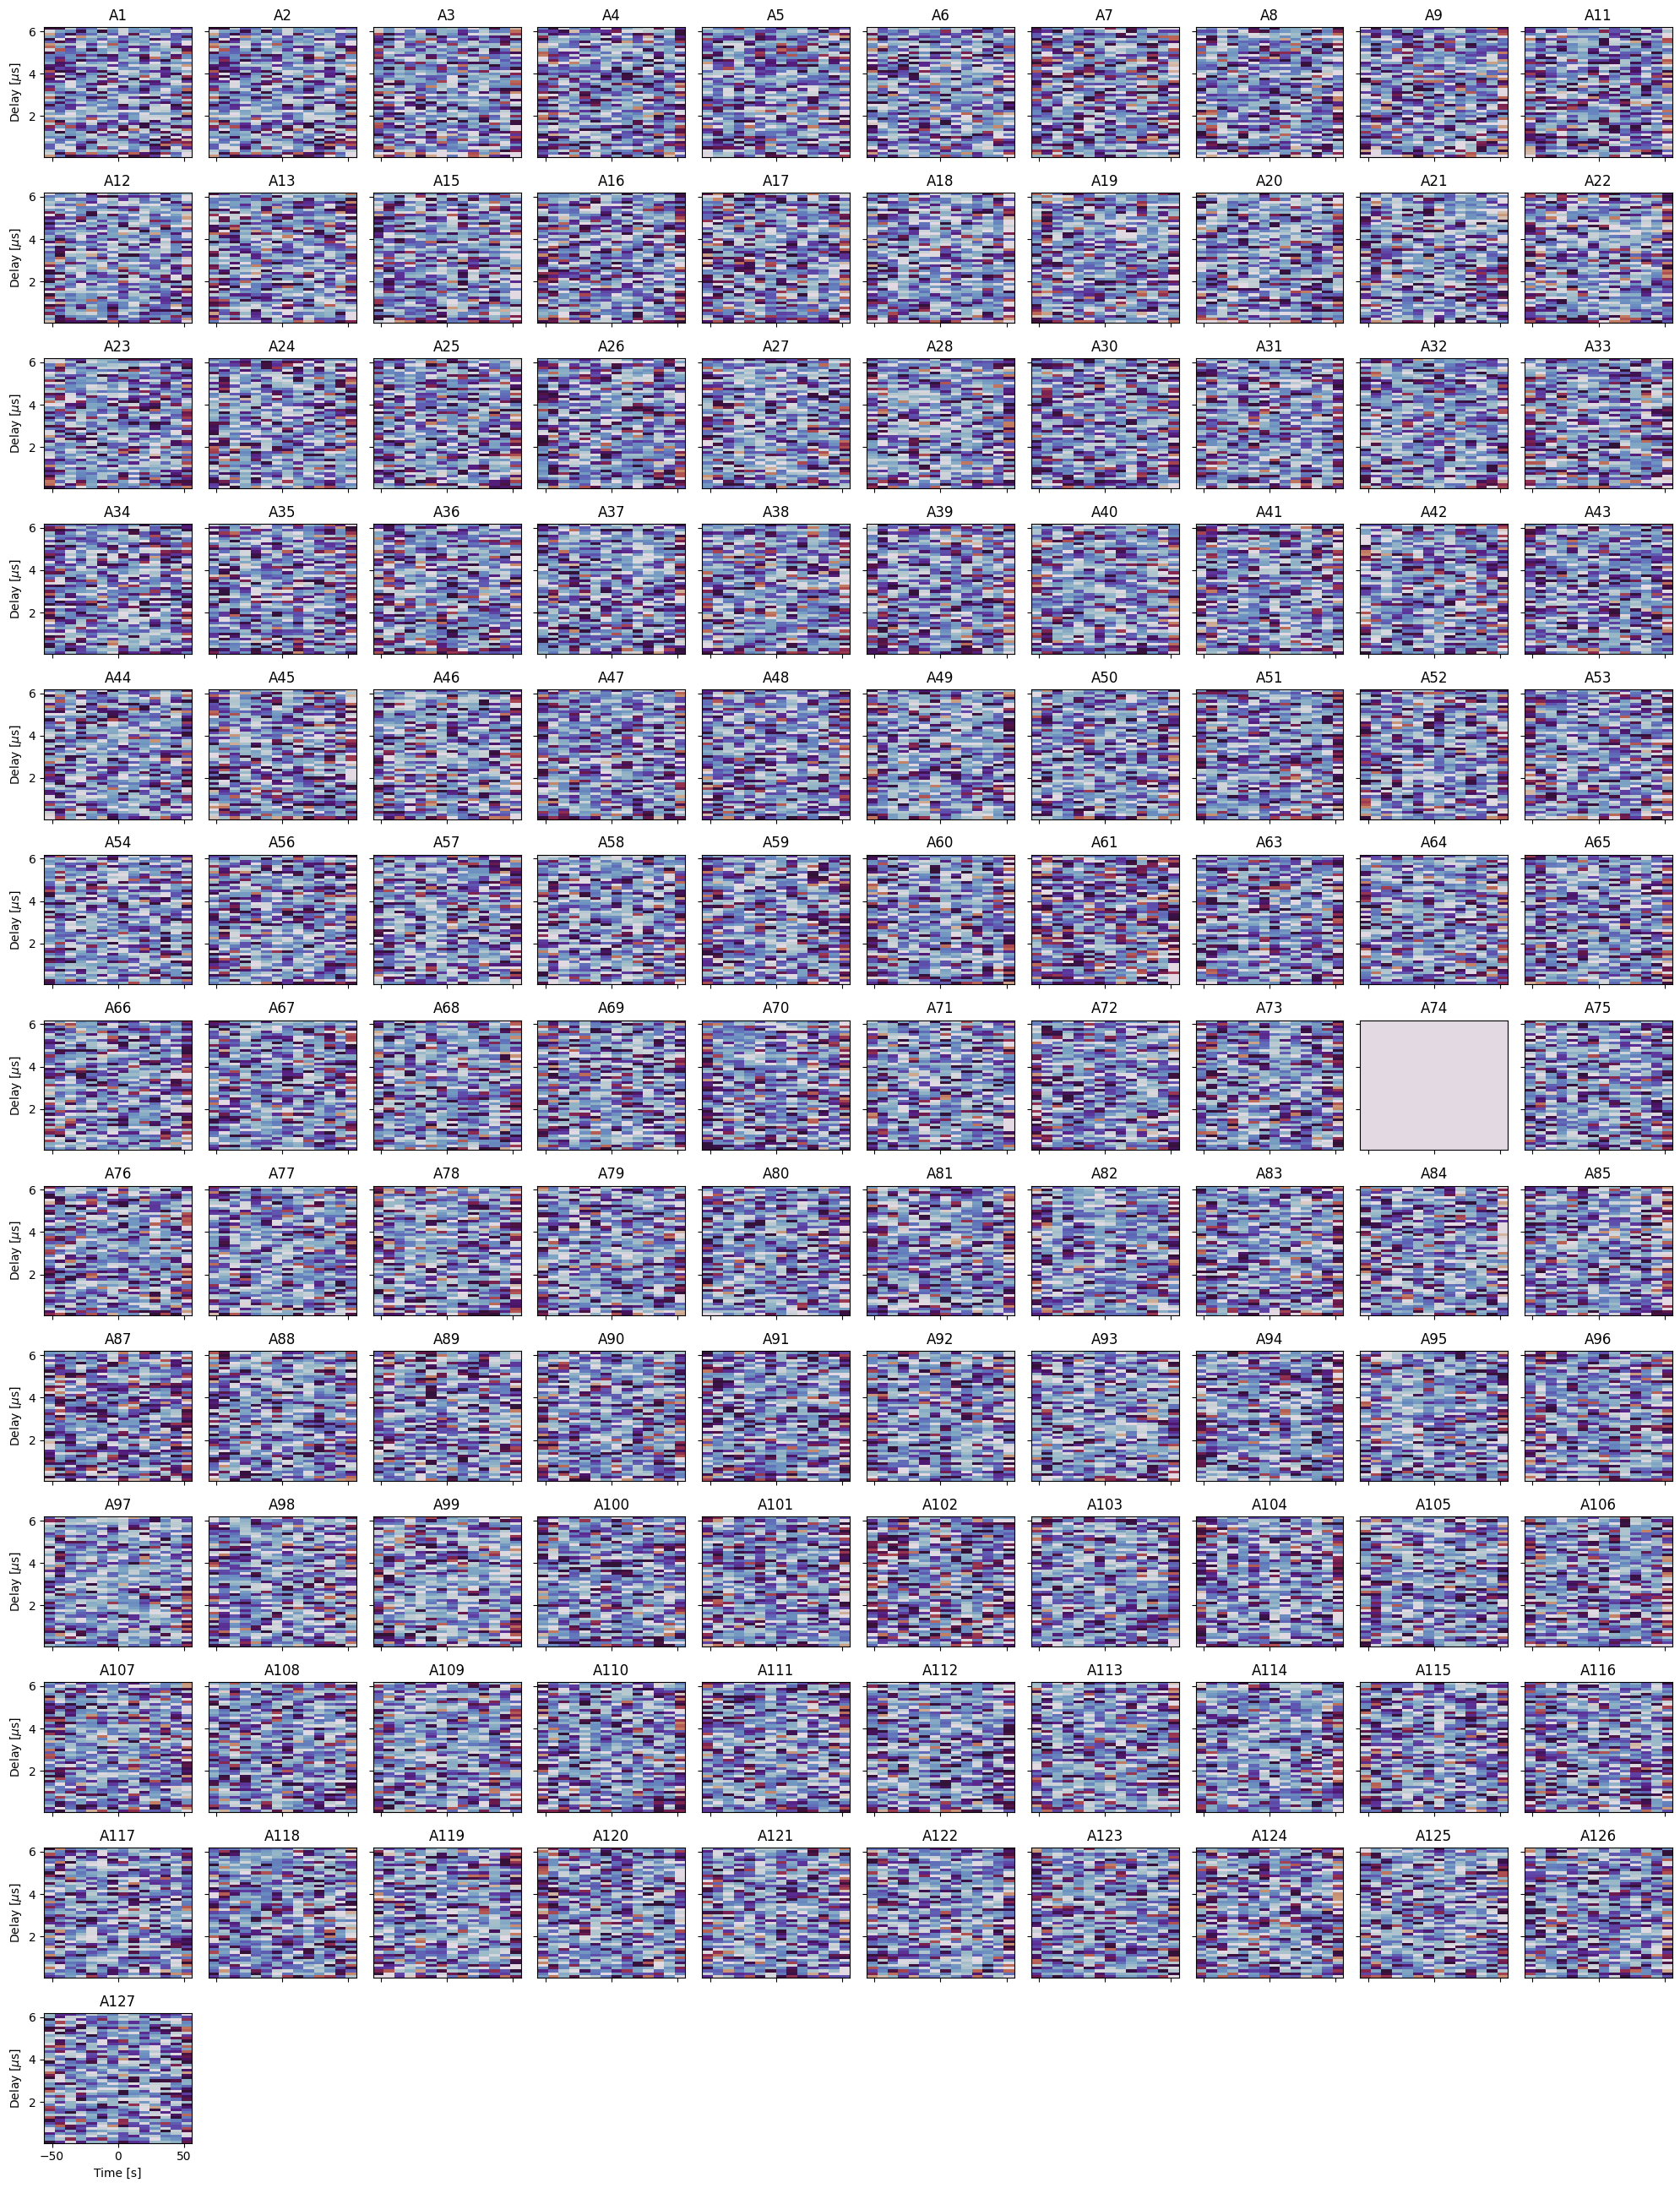

In [13]:
ncol = 10
nrow = np.ceil(len(dic['antenna_nums'])/ncol).astype(int)

vmin = np.percentile(np.abs(data_per_antenna), 2)
vmax = np.percentile(np.abs(data_per_antenna), 98)

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2*nrow), sharex=True, sharey=True)
for i, antenna_num in enumerate(dic['antenna_nums']):
    ax = axes.flatten()[i]
    im = ax.pcolormesh(
        time_array,
        uvp.get_dlys(0)*1e6,
        np.abs(data_per_antenna[i]).T,
        cmap='twilight',
        norm=colors.Normalize(vmin=vmin, vmax=vmax),
    )
    ax.set_title(f'A{antenna_num}')
    if i % ncol == 0:
        ax.set_ylabel(r'Delay [$\mu$s]')
    if i >= (nrow-1)*ncol:
        ax.set_xlabel('Time [s]')
for i in np.arange(ncol * nrow % len(dic['antenna_nums'])):
    axes.flatten()[-i-1].set_visible(False)
fig.tight_layout()